# MNIST task achieved by Gradient Descent of Tensorflow

This note utilised the part ability of Tensorflow (Gradient Descent) to achieve the aim of recognition of number image. The dataset comes from MNIST. It has 60000 training examples and 10000 test examples. The result data (notation as Y) is preprocessed to "One-Hot" format. Following this notebook, it will step-by-step take you to create a complete Neural Networks Model.

## Load Data

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

np.set_printoptions(suppress=True)
np.seterr(divide = 'ignore') 

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

# normalisation
X_train = X_train / 255
X_test = X_test / 255

def formatY(y):
    Y = np.zeros(10)
    Y[y] = 1
    return Y

# reshape
X_train = X_train.reshape(60000, 28 ** 2)
X_test = X_test.reshape(10000, 28 ** 2)
y_train = np.array([formatY(y) for y in y_train])
y_test =np.array([formatY(y) for y in y_test])

# tensorflow
X_train = tf.constant(X_train, dtype=tf.float64)
X_test = tf.constant(X_test, dtype=tf.float64)
y_train = tf.constant(y_train, dtype=tf.float64)
y_test = tf.constant(y_test, dtype=tf.float64)

11493376/11490434 [==============================] - 0s 0us/step


## Initialize HyperParameters

In [ ]:
def inistial_parameters(n, dims):
    
    W = {}
    B = {}
    
    for i in range(len(dims)):
        dim = dims[i]
        if i == 0:
            w =  np.random.rand(n, dim) * 1e-3 #* (np.sqrt(2 / dim))
            W['W' + str(i + 1)] = tf.constant(w)
            b = np.zeros((1, dim))
            B['b' + str(i + 1)] = tf.constant(b)
        else:
            w = np.random.rand(dims[i-1], dim) * 1e-3 #* (np.sqrt(2 / dim))
            W['W' + str(i + 1)] = tf.constant(w)
            b = np.zeros((1, dim))
            B['b' + str(i + 1)] = tf.constant(b)
            
    return {
        'W' : W,
        'b' : B
    }

## Linear Regression

In [ ]:
def linear(X, W, b):
    return np.dot(X, W) + b

## ReLU

In [ ]:
def relu(X):
    return np.maximum(X, 0)

## Softmax

In [ ]:
def softmax(X):
    return np.exp(X) / (np.sum(np.exp(X), axis=1, keepdims=True)) 

## Activation function

In [ ]:
def activation(A_prev, W, b, active):
    """
    activation - relu/softmax
    """
    
    if active == 'relu':
        Z = linear(A_prev, W, b)
        A = relu(Z)
    elif active == 'softmax':
        Z = linear(A_prev, W, b)
        A = softmax(Z)
        
    return A, Z

## L model forward

In [ ]:
def L_model_forward(X, W, b):
    A = X
    L = len(b)
    # caches = {}
    
    # caches['A0'] = A
    
    for i in range(1, L):
        A_prev = A
        
        A, Z = activation(A_prev, W['W' + str(i)], b['b' + str(i)], 'relu')
        # caches['A' + str(i)] = A
        # caches['Z' + str(i)] = Z
        
    AL, ZL = activation(A, W['W' + str(L)], b['b' + str(L)], 'softmax')
    # caches['A' + str(L)] = AL
    # caches['Z' + str(L)] = ZL
    
    return AL

## CrossEntropy

In [ ]:
def crossEntropy(haty, Y):
    m = haty.shape[0]

    ce = np.sum(Y * np.log(haty))

    return - ce / m


## Train

SGDRange function will split data to subsets for achievement of SGD.

In [ ]:
def SGDRange(m, setpsize):
  sum = m
  setpsize = setpsize

  rangeArr = []

  for i in range(0, (sum // setpsize) * setpsize, setpsize):
    rangeArr.append([i, i + setpsize])
    
  if sum % setpsize != 0:
    lastone = sum // setpsize * setpsize
    rangeArr.append([lastone, lastone + sum % setpsize])
  return rangeArr

# debug
# rangeArr = SGDRange(124, 50)
# print(rangeArr)

In [ ]:
n = X_train.shape[1]
alpha = 0.1

dims = [512, 10]
L = len(dims)

parameters = inistial_parameters(n, dims)
W = parameters['W']
b = parameters['b']

# AL, caches = L_model_forward(X_train, W, b)

cost_train = []
cost_test = []

def backpropagation(X, y):
    m = X.shape[0]

    with tf.GradientTape(persistent=True) as g:
        
        for i in range(1, L + 1):
            g.watch(W['W' + str(i)])
            g.watch(b['b' + str(i)])

        # ReLU
        A_previous = X
        for i in range(1, L):
            L_hidden = tf.experimental.numpy.dot(A_previous, W['W' + str(i)]) + b['b' + str(i)]
            A_previous = tf.math.maximum(L_hidden, 0) 

        # softmax
        LL = tf.experimental.numpy.dot(A_previous, W['W' + str(L)]) + b['b' + str(L)]
        AL = (tf.experimental.numpy.exp(LL)) / (tf.experimental.numpy.sum(tf.experimental.numpy.exp(LL), axis=1, keepdims=True)) 

        # cost function
        J = - tf.experimental.numpy.sum(y * tf.experimental.numpy.log(AL)) / m
    
    for i in range(1, L + 1):
        
        dJ_W = g.gradient(J, W['W' + str(i)])
        dJ_b = g.gradient(J, b['b' + str(i)])

        W['W' + str(i)] = W['W' + str(i)] - alpha * dJ_W
        b['b' + str(i)] = b['b' + str(i)] - alpha * dJ_b

iteration = 40
for i in range(iteration):

  rangeArr = SGDRange(X_train.shape[0], 512)
  for index in rangeArr:
    backpropagation(X_train[index[0]:index[1]], y_train[index[0]:index[1]])

  cost_train.append(crossEntropy(L_model_forward(X_train, W, b), y_train))
  cost_test.append(crossEntropy(L_model_forward(X_test, W, b), y_test))

  if i % 5 == 0 or i == iteration - 1:
    print('====enoch == {enoch}===='.format(enoch=i))
    print('cost_train: {cost_train}'.format(cost_train=cost_train[i]))
    print('cost_test: {cost_test}'.format(cost_test=cost_test[i]))



====enoch == 0====
cost_train: 1.8709932150979665
cost_test: 1.8652161279462922
====enoch == 5====
cost_train: 0.33255059069228365
cost_test: 0.3201571259964204
====enoch == 10====
cost_train: 0.2601728515968153
cost_test: 0.25315654257532205
====enoch == 15====
cost_train: 0.21736805206427454
cost_test: 0.21382235900617397
====enoch == 20====
cost_train: 0.18549993119361605
cost_test: 0.18474472488356808
====enoch == 25====
cost_train: 0.16070849438859428
cost_test: 0.16264182783442965
====enoch == 30====
cost_train: 0.1410160678928834
cost_test: 0.14566523833924244
====enoch == 35====
cost_train: 0.12509860787396332
cost_test: 0.13243227396503532
====enoch == 39====
cost_train: 0.11442393794352002
cost_test: 0.12386539380015027


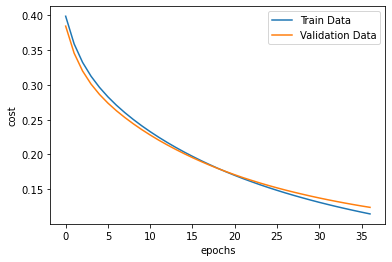

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cost_train[3:], label="Train Data")
plt.plot(cost_test[3:], label="Validation Data")
plt.ylabel('cost')
plt.xlabel('epochs')
plt.legend()
plt.show()

## get correct percentage

In [ ]:
def getCorrectPercentage(X, y):
  m = len(X)
  hatys = L_model_forward(X, W, b)
  hatys = np.array([formatY(np.argmax(y)) for y in hatys])
  corrent_num = np.sum(y * hatys)
  return corrent_num / m

print(getCorrectPercentage(X_train, y_train))
print(getCorrectPercentage(X_test, y_test))

0.9683333333333334
0.9637


[[0.00120699 0.00002506 0.98845701 0.00928377 0.         0.00037926
  0.00032382 0.         0.00032408 0.        ]]
2


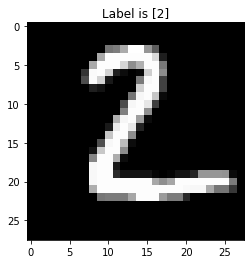

In [ ]:
## Test
index = 1
single_label = np.where(y_test[index] == 1)[0]
single_Image = X_test[index].numpy()
single_Image_r = single_Image.reshape((28, 28))
test = L_model_forward(single_Image, W, b)
print(test)
print(np.argmax(test))
plt.title('Label is {label}'.format(label=single_label))
plt.imshow(single_Image_r, cmap='gray')
plt.show()

In [ ]:
test_data = pd.read_csv('/content/test.csv')
test_data = test_data / 255
test_data.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,...,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000005,0.000049,0.000066,0.000124,0.000220,0.000394,0.000655,...,0.012833,0.009300,0.005703,0.003319,0.001999,0.000999,0.000244,0.000060,0.000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000021,0.000095,0.000142,0.000326,0.000526,0.000789,0.001275,0.001438,0.001836,0.002311,0.002576,0.002234,0.001820,0.001269,0.000646,0.000287,0.000110,0.000044,0.000026,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000891,0.006142,0.005935,0.010488,0.012613,0.017841,0.021453,...,0.098869,0.083294,0.065269,0.049561,0.039074,0.027575,0.011924,0.004963,0.000516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002512,0.008765,0.009780,0.014815,0.019400,0.024560,0.030254,0.032328,0.035192,0.041132,0.043959,0.040016,0.036871,0.030897,0.021464,0.014184,0.007112,0.004726,0.003167,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,

In [ ]:
hatys = L_model_forward(test_data, W, b)
hatys = np.array([np.argmax(y) for y in hatys])
    
hatys = pd.DataFrame(zip(range(1, len(hatys) + 1), hatys), columns=['ImageId', 'Label'])
print(hatys)

       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      9
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]


In [ ]:
hatys.to_csv('submission.csv', index=False)

In [ ]:
import pickle

# save pickle
filename = 'model.pkl'
model = {'W': W, 'b': b}
pickle.dump( model, open( filename, "wb" ) )

In [ ]:
# load pickle
model = pickle.load( open( filename, "rb" ) )
print(model)

{'W': {'W1': <tf.Tensor: shape=(784, 512), dtype=float64, numpy=
array([[0.00059625, 0.0003933 , 0.00086785, ..., 0.00004858, 0.00013379,
        0.00072218],
       [0.00008176, 0.00020808, 0.00087247, ..., 0.00031483, 0.00028947,
        0.00087381],
       [0.00060837, 0.00019523, 0.00022169, ..., 0.00024983, 0.00056518,
        0.00084179],
       ...,
       [0.00051276, 0.00079527, 0.00073196, ..., 0.00087327, 0.0001117 ,
        0.00095047],
       [0.00025562, 0.00063432, 0.00098423, ..., 0.00098407, 0.00010416,
        0.00084661],
       [0.00063168, 0.00042199, 0.00028202, ..., 0.00071671, 0.00044832,
        0.00074504]])>, 'W2': <tf.Tensor: shape=(512, 10), dtype=float64, numpy=
array([[-0.03960964, -0.05654916, -0.09718664, ..., -0.08110619,
         0.02034825, -0.04291938],
       [-0.03432546, -0.08943601,  0.2000573 , ...,  0.00238561,
         0.05304944, -0.04931454],
       [-0.01129258, -0.0534653 ,  0.09417206, ..., -0.05689573,
         0.03362151, -0.0435891 ],